<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/states/daily"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/04-07-2020.csv"

#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/
#csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv
dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [88]:
dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(),\
  ['state', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,state,positive,negative
37,NY,138863,201195
34,NJ,44416,50558
24,MI,18970,31362
20,LA,16284,58371
5,CA,15865,115364
21,MA,15202,66142
10,FL,14747,123415
41,PA,14559,76719
16,IL,13549,55183
11,GA,8818,24895


In [0]:
gbUSA = dfCovidtracking.groupby(['date'])
gbCA = dfCovidtracking[dfCovidtracking.state=='CA'].groupby(['date'])

dfUSAPos = gbUSA.positive.sum().reset_index().copy()
dfCAPos = gbCA.positive.sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 
dfUSAPos['PCT']= dfUSAPos.positive/dfUSAPos.max().positive
dfCAPos['PCT']=dfCAPos.positive/dfCAPos.max().positive

In [90]:
dfUSAPos[-7:]

,date,positive,PCT
28,2020-04-01,210816,0.536982
29,2020-04-02,239099,0.609024
30,2020-04-03,271988,0.692797
31,2020-04-04,305755,0.778807
32,2020-04-05,332308,0.846442
33,2020-04-06,361331,0.920368
34,2020-04-07,392594,1.000000


In [91]:
dfCAPos[-7:]

,date,positive,PCT
28,2020-04-01,8155,0.514025
29,2020-04-02,9191,0.579326
30,2020-04-03,10701,0.674504
31,2020-04-04,12026,0.758021
32,2020-04-05,13438,0.847022
33,2020-04-06,14336,0.903624
34,2020-04-07,15865,1.000000


In [92]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-03,271988,1124874,61980,19926.0,35991.0,4686.0,593.0,70.0,728.0,10422.0,6962,35991.0,1458842,1396862,1396862,1178.0,3509.0,96225.0,32889.0,129114.0
2020-04-04,305755,1318592,15573,22158.0,38402.0,5207.0,691.0,656.0,154.0,12784.0,8314,38402.0,1639920,1624347,1624347,1352.0,4404.0,193718.0,33767.0,227485.0
2020-04-05,332308,1429724,17307,23061.0,41372.0,5497.0,913.0,612.0,193.0,14486.0,9498,41372.0,1779339,1762032,1762032,1184.0,3322.0,111132.0,26553.0,137685.0
2020-04-06,361331,1547026,17292,27675.0,45168.0,6607.0,971.0,2932.0,187.0,16006.0,10680,45168.0,1925649,1908357,1908357,1182.0,3796.0,117302.0,29023.0,146325.0
2020-04-07,392594,1661868,16557,39011.0,45562.0,9649.0,932.0,4007.0,229.0,17809.0,12621,45562.0,2071019,2054462,2054462,1941.0,3516.0,114842.0,31263.0,146105.0


In [93]:
gbCA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-03,10701,24599,59500,2188.0,0.0,901.0,0.0,0.0,0.0,0.0,237,0.0,94800,35300,35300,34.0,0.0,790.0,1510.0,2300.0
2020-04-04,12026,101674,13000,2300.0,0.0,1008.0,0.0,0.0,0.0,0.0,276,0.0,126700,113700,113700,39.0,0.0,77075.0,1325.0,78400.0
2020-04-05,13438,103095,15000,2398.0,0.0,1040.0,0.0,0.0,0.0,0.0,319,0.0,131533,116533,116533,43.0,0.0,1421.0,1412.0,2833.0
2020-04-06,14336,103095,15000,2509.0,0.0,1085.0,0.0,0.0,0.0,0.0,343,0.0,132431,117431,117431,24.0,0.0,0.0,898.0,898.0
2020-04-07,15865,115364,14100,2611.0,0.0,1108.0,0.0,0.0,0.0,0.0,374,0.0,145329,131229,131229,31.0,0.0,12269.0,1529.0,13798.0


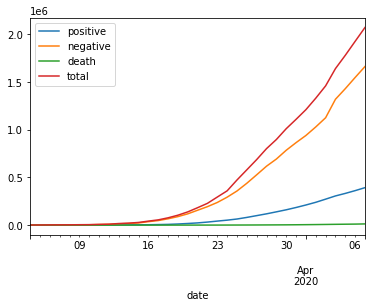

In [94]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [95]:
dfWHO[-14:]

,confirmed,who_deaths
date,,
2020-03-25,51914,673
2020-03-26,63570,884
2020-03-27,68334,991
2020-03-28,85228,1243
2020-03-29,103321,1668
2020-03-30,122653,2112
2020-03-31,140640,2398
2020-04-01,163199,2850
2020-04-02,187302,3846


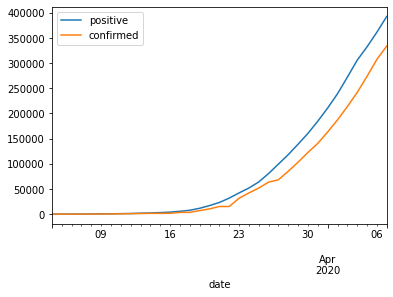

In [96]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

In [97]:
gbCA.sum()[-7:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-04-01,8155,21772,57400,1855.0,1855.0,774.0,774.0,0.0,0.0,0.0,171,1855.0,87327,29927,29927,18.0,238.0,0.0,673.0,673.0
2020-04-02,9191,23809,59500,1922.0,0.0,816.0,0.0,0.0,0.0,0.0,203,0.0,92500,33000,33000,32.0,0.0,2037.0,1036.0,3073.0
2020-04-03,10701,24599,59500,2188.0,0.0,901.0,0.0,0.0,0.0,0.0,237,0.0,94800,35300,35300,34.0,0.0,790.0,1510.0,2300.0
2020-04-04,12026,101674,13000,2300.0,0.0,1008.0,0.0,0.0,0.0,0.0,276,0.0,126700,113700,113700,39.0,0.0,77075.0,1325.0,78400.0
2020-04-05,13438,103095,15000,2398.0,0.0,1040.0,0.0,0.0,0.0,0.0,319,0.0,131533,116533,116533,43.0,0.0,1421.0,1412.0,2833.0
2020-04-06,14336,103095,15000,2509.0,0.0,1085.0,0.0,0.0,0.0,0.0,343,0.0,132431,117431,117431,24.0,0.0,0.0,898.0,898.0
2020-04-07,15865,115364,14100,2611.0,0.0,1108.0,0.0,0.0,0.0,0.0,374,0.0,145329,131229,131229,31.0,0.0,12269.0,1529.0,13798.0


In [98]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    396223
dead          12722
dtype: int64

In [99]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    17351
dead           432
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [101]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                396223
Spain             141942
Italy             135586
France            110065
Germany           107663
China              82718
Iran               62589
United Kingdom     55949
Turkey             34109
Switzerland        22253
Name: confirmed, dtype: int64

In [0]:
dfData = dfCovidtracking.groupby('date')

In [0]:
dfStateTotal = dfCovidtracking[['state', 'positive']].groupby(by='state').max() \
.rename(columns={'positive':'current_total'})


In [0]:
dfState = dfCovidtracking[['date','state','positive']].set_index('state') \
  .join(dfStateTotal)

In [0]:
dfState['pct']=dfState.positive/dfState.current_total

In [106]:
dfState.loc['FL'].head(7)

,date,positive,current_total,pct
state,,,,
FL,2020-04-07,14747,14747,1.000000
FL,2020-04-06,13324,14747,0.903506
FL,2020-04-05,12151,14747,0.823964
FL,2020-04-04,11111,14747,0.753441
FL,2020-04-03,9585,14747,0.649963
FL,2020-04-02,8010,14747,0.543161
FL,2020-04-01,6955,14747,0.471621


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

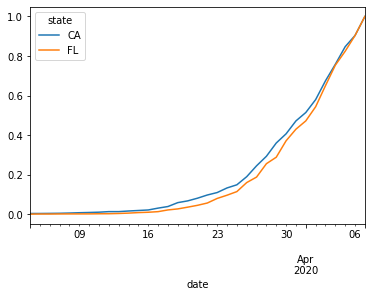

In [108]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

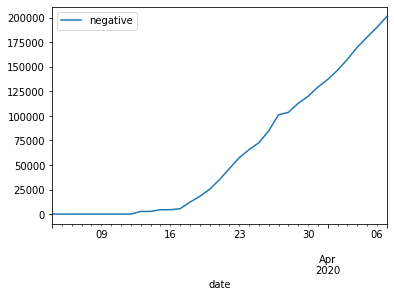

In [110]:
x = dfNYTesting.plot.line()

In [111]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,current_total,pct
324,FL,2020-04-07,14747,14747,1.000000
325,FL,2020-04-06,13324,14747,0.903506
326,FL,2020-04-05,12151,14747,0.823964
327,FL,2020-04-04,11111,14747,0.753441
328,FL,2020-04-03,9585,14747,0.649963
329,FL,2020-04-02,8010,14747,0.543161
330,FL,2020-04-01,6955,14747,0.471621
331,FL,2020-03-31,6338,14747,0.429782
332,FL,2020-03-30,5473,14747,0.371126
333,FL,2020-03-29,4246,14747,0.287923


In [125]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=4)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .66)].sort_values(by='positive',ascending=False)


,state,date,positive,current_total,pct
652,LA,2020-04-03,10297,16284,0.632338
328,FL,2020-04-03,9585,14747,0.649963
518,IL,2020-04-03,8904,13549,0.657170
1344,PA,2020-04-03,8420,14559,0.578336
1533,TX,2020-04-03,5330,8262,0.645122
229,CT,2020-04-03,4914,7781,0.631538
553,IN,2020-04-03,3437,5507,0.624115
719,MD,2020-04-03,2758,4371,0.630977
971,NC,2020-04-03,2093,3221,0.649798
1600,VA,2020-04-03,2012,3333,0.603660


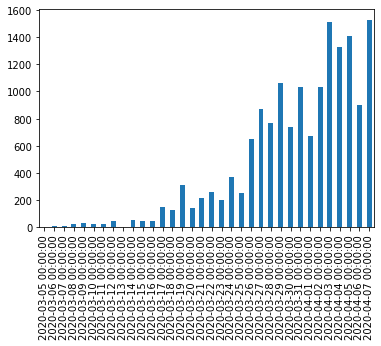

In [126]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar()



# Added State Data

In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [128]:
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
print(res)
print(f"Current Infection Rate {res.positive/res.total*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")

positive     392594
negative    1661868
pending       16557
death         12621
total       2071019
dtype: int64
Current Infection Rate 18.956562%
Percentage of US affected: 0.123451%
Percentage of US tested/affected: 0.629748%


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [124]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.negative / dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:25]

,state_pos_pop,state_test_pop
state,,
NY,0.713818,1.034232
NJ,0.500057,0.569206
LA,0.350284,1.255616
MA,0.220558,0.959622
CT,0.218243,0.596165
MI,0.189950,0.314033
DC,0.171591,0.936877
RI,0.116013,0.698440
PA,0.113725,0.599274
